In [14]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN


from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import FinanceDataReader as fdr
from sklearn.metrics import accuracy_score

In [9]:


#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_26=df["Close"].rolling(26).mean()
    MA_52=df["Close"].rolling(52).mean()
    df=df.assign(MA_26=MA_26,MA_52=MA_52).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df
   
    #시간
def get_time(df):
    time=np.linspace(0,10,len(df),endpoint=False).reshape(-1,1)
    df=df.assign(time=time)
    
    return df




def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)


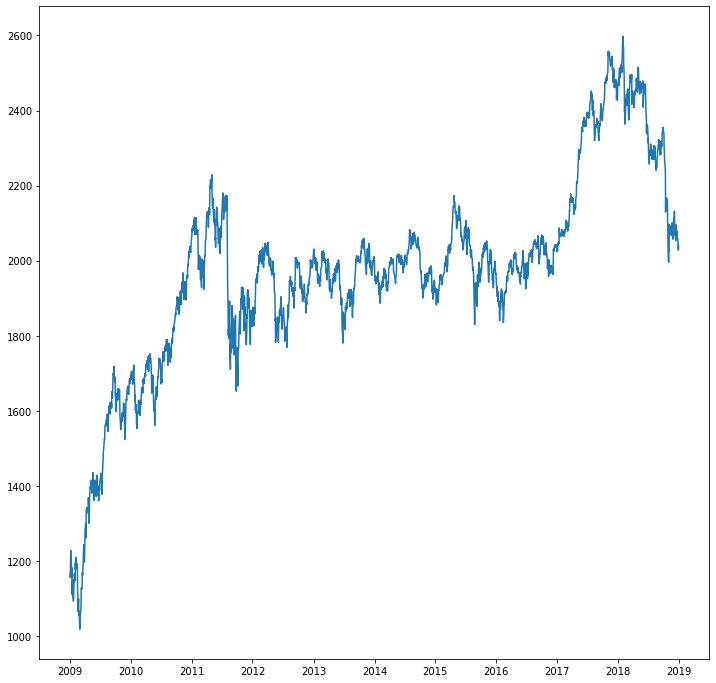

In [12]:
plt.figure(figsize=(12, 12))
plt.plot(pandf["Close"])

In [13]:
# convert nparray
nparr = pandf.values
nparr.astype('float32')
print(nparr)

[[ 1.15740e+03  1.13287e+03  1.15740e+03  1.11884e+03  3.40780e+08
   2.93000e-02]
 [ 1.17357e+03  1.18098e+03  1.18522e+03  1.16666e+03  4.14760e+08
   1.40000e-02]
 [ 1.19428e+03  1.18352e+03  1.20359e+03  1.17994e+03  4.44200e+08
   1.76000e-02]
 ...
 [ 2.02801e+03  2.02881e+03  2.03783e+03  2.01428e+03  3.21500e+08
  -1.31000e-02]
 [ 2.02844e+03  2.03209e+03  2.03557e+03  2.02139e+03  3.98020e+08
   2.00000e-04]
 [ 2.04104e+03  2.03670e+03  2.04697e+03  2.03541e+03  3.52680e+08
   6.20000e-03]]


In [14]:
# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
nptf = scaler.fit_transform(nparr)

In [15]:
nptf=nptf[:-1]

In [16]:
# split train, test
y=np.where(pandf["Change"].shift(-1).dropna()>0,1,0)
train_size = int(len(nptf) * 0.7)
y_train=y[:train_size]
y_test=y[train_size:]
X_train = nptf[:train_size]
X_test = nptf[train_size:]

In [17]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [18]:
# simple lstm network learning
model = Sequential()
model.add(SimpleRNN(36, input_shape=(1, 6)))
for i in range(5):
    model.add(Dense(36,activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, batch_size=16,validation_split=0.1)
model.evaluate(X_test,y_test)

Train on 1557 samples, validate on 174 samples
Epoch 1/100
1557/1557 [==============================] - 1s 368us/step - loss: 0.6943 - acc: 0.5106 - val_loss: 0.6934 - val_acc: 0.4828
Epoch 2/100
1557/1557 [==============================] - 0s 111us/step - loss: 0.6961 - acc: 0.4875 - val_loss: 0.6947 - val_acc: 0.4828
Epoch 3/100
1557/1557 [==============================] - 0s 99us/step - loss: 0.6947 - acc: 0.4978 - val_loss: 0.6938 - val_acc: 0.4828
Epoch 4/100
1557/1557 [==============================] - 0s 114us/step - loss: 0.6953 - acc: 0.5016 - val_loss: 0.6961 - val_acc: 0.4828
Epoch 5/100
1557/1557 [==============================] - 0s 105us/step - loss: 0.6949 - acc: 0.5074 - val_loss: 0.6926 - val_acc: 0.5172
Epoch 6/100
1557/1557 [==============================] - 0s 121us/step - loss: 0.6958 - acc: 0.5003 - val_loss: 0.6980 - val_acc: 0.4828
Epoch 7/100
1557/1557 [==============================] - 0s 115us/step - loss: 0.6933 - acc: 0.5183 - val_loss: 0.6942 - val_acc: 0.

[0.7044661931914461, 0.47304582595825195]

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,np.where(model.predict(X_test)>0.5,1,0))

0.47304582210242585

In [13]:
a=model.evaluate(X_test,y_test)

742/742 [==============================] - 0s 42us/step


In [14]:
a

[0.7071411326889079, 0.4743935167789459]

In [4]:
X_train

NameError: name 'X_train' is not defined

In [1]:
a=[1,2,3,4,5]
a=a[:-1]

In [16]:
df_test

,Close,Open,High,Low,Volume,Change,kdj_k,kdj_d,kdj_j,MA_26,MA_52,RSI_14D
Date,,,,,,,,,,,,
2010-04-07,1726.60,1725.31,1729.23,1722.19,3.997500e+08,0.0003,90.631424,91.728116,91.977546,1678.704231,1644.304423,53.553213
2010-04-08,1733.78,1722.13,1733.78,1719.51,3.625500e+08,0.0042,100.000000,94.485411,93.231479,1682.986538,1645.255000,52.334427
2010-04-09,1724.47,1735.00,1737.45,1710.11,4.525300e+08,-0.0054,82.113821,90.361548,91.796513,1687.073846,1646.298654,56.398300
2010-04-12,1710.30,1730.37,1733.30,1707.92,4.166400e+08,-0.0082,55.049669,78.590921,85.193717,1689.986538,1647.701731,49.471027
2010-04-13,1710.59,1714.96,1716.09,1699.58,3.696200e+08,0.0002,55.529801,70.903881,78.048799,1691.930769,1649.338462,41.985969
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-17,1914.53,1893.31,1926.02,1893.19,1.670000e+09,0.0309,95.681588,94.952091,94.181071,1730.411923,1924.689231,59.310654
2020-04-20,1898.36,1908.34,1925.25,1893.17,1.090000e+09,-0.0084,89.604239,93.169474,93.675273,1732.874615,1919.549423,56.366189
2020-04-21,1879.38,1886.78,1898.32,1841.66,1.170000e+09,-0.0100,82.190996,89.509981,91.592627,1737.026154,1912.846346,57.459710


In [20]:
df = fdr.DataReader("KS11")
df=get_stochastic(df)
df=get_MA(df)
df['Momentum_1D'] = (df['Close']-df['Close'].shift(1))
df['RSI_14D'] = df['Momentum_1D'].rolling(center=False, window=14).apply(rsi)
df=df.dropna()
df=df[0:-(len(df)%20)]
df = df.drop(labels = ['Momentum_1D','High','Low','Change','Volume'], axis=1)

df_test=df
MA_26=df["Close"].rolling(21).mean()
y_before=MA_26.dropna()

dfA=df[20:] #값과 값 -> [:] 이평선 -> [20:]  <- [20: 0 XXXX]
df_test3=dfA
y=np.where(np.array(dfA["Close"].shift(-1).dropna())>np.array(y_before.shift(-1).dropna()),1,0) #값과 이평선 ( 1일 차 )
#y=np.where(dfA["Change"].shift(-1).dropna()>0,1,0) #값과 값 ( 1일 차 )
#y=np.where(np.array(dfA["Close"].shift(-20).dropna())>np.array(y_before.shift(-20).dropna()),1,0) #값과 이평선( 20일 차 )
#y=np.where(dfA["Change"].shift(-20).dropna()>0,1,0) #값과 값 ( 20일 차 )

df = dfA[:-1] # 1일차일시 [:-1] 20일차일시 [:-20]
df_test2=df

nparr=df
scaler = MinMaxScaler(feature_range=(0, 1))

df2=pd.DataFrame(columns=["Close","Open","kdj_k","kdj_d","kdj_j","MA_26","MA_52","RSI_14D"])

df2["Close"]=scaler.fit_transform(nparr["Close"].values.reshape(-1,1))[:,0]
df2["Open"]=scaler.fit_transform(nparr["Open"].values.reshape(-1,1))[:,0]
# df2["High"]=scaler.fit_transform(nparr["High"].values.reshape(-1,1))[:,0]
# df2["Low"]=scaler.fit_transform(nparr["Low"].values.reshape(-1,1))[:,0]
# df2["Volume"]=scaler.fit_transform(nparr["Volume"].values.reshape(-1,1))[:,0]
# df2["Change"]=scaler.fit_transform(nparr["Change"].values.reshape(-1,1))[:,0]
df2["kdj_k"]=scaler.fit_transform(nparr["kdj_k"].values.reshape(-1,1))[:,0]
df2["kdj_d"]=scaler.fit_transform(nparr["kdj_d"].values.reshape(-1,1))[:,0]
df2["kdj_j"]=scaler.fit_transform(nparr["kdj_j"].values.reshape(-1,1))[:,0]
df2["MA_26"]=scaler.fit_transform(nparr["MA_26"].values.reshape(-1,1))[:,0]
df2["MA_52"]=scaler.fit_transform(nparr["MA_52"].values.reshape(-1,1))[:,0]
df2["RSI_14D"]=scaler.fit_transform(nparr["RSI_14D"].values.reshape(-1,1))[:,0]

X=df2.values

setlen=int(len(X)/20*0.7)*20

X_train=X[:setlen]
X_test=X[setlen:]
y_train=y[:setlen]
y_test=y[setlen:]

X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(36, input_shape=(1, 8),return_sequences=True))
model.add(LSTM(36, input_shape=(1, 8)))
for i in range(2):
    model.add(Dense(18,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, batch_size=32,validation_split=0.1,verbose=0)
pred=np.where(model.predict(X_test)>0.5,1,0)

print("KS11", "정확도 : ", accuracy_score(y_test,np.where(model.predict(X_test)>0.5,1,0)))

KS11 정확도 :  0.8755074424898511
